## Value-at-Risk: Using Historical Simulation

**Functions**

`Series.quantile`, `Series.rolling`

### Exercise 58
Compute the 1-, 5- and 10-day historical simulation VaR for the S&P 500 and the EUR/USD rate.
    
**Note**: Start the historical simulation at 25% of the data, and then build the additional forecasts using a recursive
scheme.

In [1]:
%matplotlib inline

import pandas as pd
sp500 = pd.read_hdf("./data/arch-data.h5", "sp500")        
eurusd = pd.read_hdf("./data/arch-data.h5", "eurusd")

sp500_returns = 100 * sp500.SP500.pct_change().dropna()
eurusd_returns = 100 * eurusd.DEXUSEU.pct_change().dropna()

### Explanation

In [2]:
start = int(sp500_returns.shape[0] * 0.25)
var_95_1day = sp500_returns.expanding(min_periods=start).quantile(0.05)

### Explanation

In [3]:
rets_5_day = sp500_returns.rolling(5).sum().dropna()
var_95_5day = rets_5_day.expanding(min_periods=start).quantile(0.05)


### Explanation

In [4]:
rets_10_day = sp500_returns.rolling(10).sum().dropna()
var_95_10day = rets_10_day.expanding(min_periods=start).quantile(0.05)


### Explanation

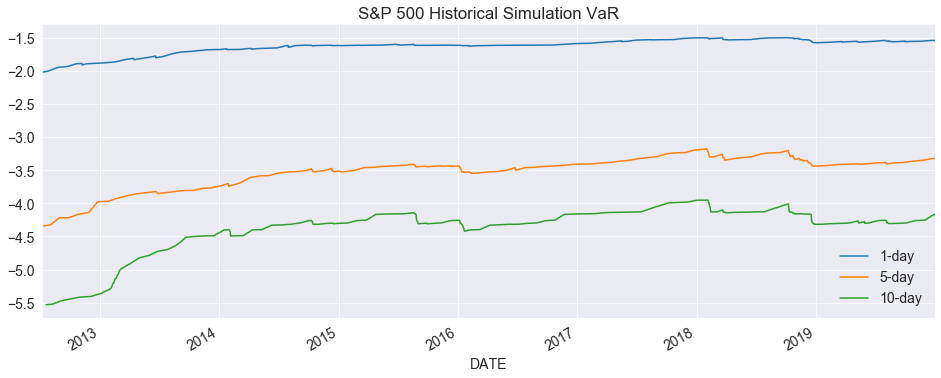

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.rc("figure",figsize=(16,6))
plt.rc("font",size=14)

value_at_risks = pd.concat([var_95_1day, var_95_5day, var_95_10day], axis=1)
value_at_risks = value_at_risks.dropna(how="all")
value_at_risks.columns = ["1-day","5-day","10-day"]
ax = value_at_risks.plot(legend=False)
ax.set_title("S&P 500 Historical Simulation VaR")
plt.legend(frameon=False)


### Explanation

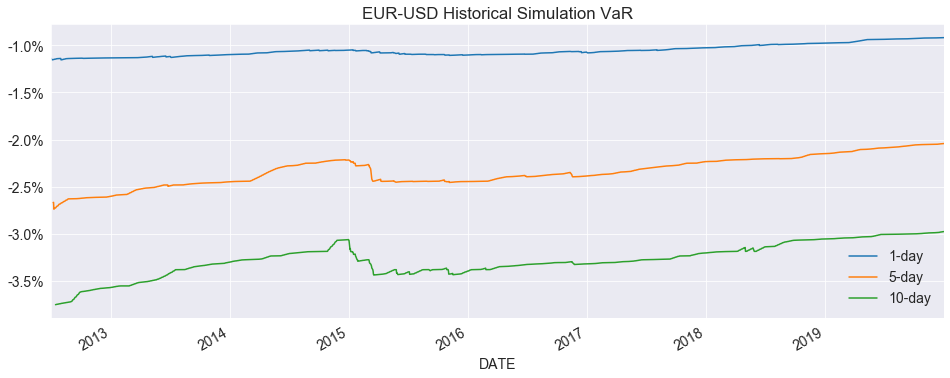

In [6]:
eurusd_value_at_risks = {}
for horizon in (1,5,10):
    multi_day_returns = eurusd_returns.rolling(horizon).sum().dropna()
    actual_var = multi_day_returns.expanding(min_periods=start).quantile(0.05)
    eurusd_value_at_risks[f"{horizon}-day"] = actual_var
eurusd_value_at_risks = pd.DataFrame(eurusd_value_at_risks).dropna(how="all")

ax = eurusd_value_at_risks.plot(legend=False)
ax.set_yticklabels([f"{tick}%" for tick in ax.get_yticks()])
ax.set_title("EUR-USD Historical Simulation VaR")
plt.legend(frameon=False)


### Explanation